In [1]:
import sqlite3
import pandas as pd
import filterbyip as fbi
import requests
import asinfo
import clusterbycolumn as cbc

In [2]:
import warnings
warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [4]:
def asn_from_probe_name(probe_name):
    base = 'http://leone-collector.eecs.jacobs-university.de/msmpoint'
    msm_metadata = requests.get('%s/%s'%(base, probe_name))
    asn4 = str(msm_metadata.json()['asn4'])
    asn6 = str(msm_metadata.json()['asn6'])
    return asn4,asn6

In [5]:
dailydb_location = '/data/vbajpai/datasets/youtube-data-collection-python3/youtube.db'

In [6]:
query = '''select   msmpoint.name as probe
                  , dtime
                  , video_address
                  , stall_events
                  , stall_duration_avg
                  , stall_duration_total
                  
           from youtube, msmpoint
           where youtube.unit_id = msmpoint.skunitid
           and msmpoint.skunitid <> ''
           
           
           order by dtime DESC
        '''

In [7]:
con = sqlite3.connect(dailydb_location)
df = pd.read_sql(query, con)

In [8]:
df.head()

,probe,dtime,video_address,stall_events,stall_duration_avg,stall_duration_total
0,samsbox08,2017-06-27 23:37:44,2001:b30:ef00:99ca::c,0,0,0
1,samsbox08,2017-06-27 23:36:40,195.95.178.204,0,0,0
2,samsbox45,2017-06-27 23:36:12,None,0,0,0
3,samsbox03,2017-06-27 23:36:00,2001:1a80:801::c,0,0,0
4,samsbox45,2017-06-27 23:35:09,173.194.20.202,0,0,0


In [9]:
num_probes = len(set(df['probe']))

In [10]:
def round_time_to_nearest_hour(dtime):
    import datetime;    
    d = datetime.datetime.strptime(dtime, "%Y-%m-%d %H:%M:%S")
    d = d.replace(minute=0, second=0)
    dtime = d.strftime('%Y-%m-%d %H:%M:%S')
    return dtime

In [11]:
df['dtime'] = df['dtime'].apply(round_time_to_nearest_hour)

In [12]:
df.head()

,probe,dtime,video_address,stall_events,stall_duration_avg,stall_duration_total
0,samsbox08,2017-06-27 23:00:00,2001:b30:ef00:99ca::c,0,0,0
1,samsbox08,2017-06-27 23:00:00,195.95.178.204,0,0,0
2,samsbox45,2017-06-27 23:00:00,None,0,0,0
3,samsbox03,2017-06-27 23:00:00,2001:1a80:801::c,0,0,0
4,samsbox45,2017-06-27 23:00:00,173.194.20.202,0,0,0


In [13]:
df.tail()

,probe,dtime,video_address,stall_events,stall_duration_avg,stall_duration_total
5241629,samsbox24,2014-08-20 04:00:00,173.194.137.147,0,0,0
5241630,samsbox24,2014-08-20 03:00:00,None,0,0,0
5241631,samsbox24,2014-08-20 02:00:00,None,0,0,0
5241632,samsbox24,2014-08-20 01:00:00,173.194.137.147,0,0,0
5241633,samsbox24,2014-08-20 00:00:00,None,0,0,0


In [14]:
df.count()

probe                   5241634
dtime                   5241634
video_address           4727767
stall_events            5241634
stall_duration_avg      5241634
stall_duration_total    5241634
dtype: int64

In [15]:
def get_af_from_endpoint(ep):
    if ep is None: return None
    elif fbi.if_ipv6(ep): return 'v6'
    elif fbi.if_ipv4(ep): return 'v4'
    else: print('.'); return None

In [16]:
df['af'] = df['video_address'].apply(get_af_from_endpoint)

.


In [17]:
df.count()

probe                   5241634
dtime                   5241634
video_address           4727767
stall_events            5241634
stall_duration_avg      5241634
stall_duration_total    5241634
af                      4727766
dtype: int64

In [18]:
df.head()

,probe,dtime,video_address,stall_events,stall_duration_avg,stall_duration_total,af
0,samsbox08,2017-06-27 23:00:00,2001:b30:ef00:99ca::c,0,0,0,v6
1,samsbox08,2017-06-27 23:00:00,195.95.178.204,0,0,0,v4
2,samsbox45,2017-06-27 23:00:00,None,0,0,0,None
3,samsbox03,2017-06-27 23:00:00,2001:1a80:801::c,0,0,0,v6
4,samsbox45,2017-06-27 23:00:00,173.194.20.202,0,0,0,v4


In [19]:
dfgroupby = cbc.group(df, column=['probe', 'af'])

In [20]:
df_agg = cbc.aggregate(dfgroupby, ['stall_events'], ['sum', 'count'])

In [21]:
df_merged = cbc.merge(df, df_agg, column=['probe', 'af'])

In [22]:
df = df_merged.drop(['dtime', 'video_address', 'stall_events', 'stall_duration_avg', 'stall_duration_total'], axis=1)

In [23]:
df = df.drop_duplicates()

In [24]:
df.head()

,probe,af,"(stall_events, sum)","(stall_events, count)"
0,samsbox08,v6,15,26892
1,samsbox08,v4,30,32804
3,samsbox03,v6,20,38994
4,samsbox45,v4,17,34372
5,samsbox03,v4,9,37683


In [25]:
df.rename( columns={  df.columns[-1]: 'stall_count'
                    , df.columns[-2]: 'stall_sum'
                    , df.columns[-3]: 'af'
                    , df.columns[-4]: 'probe'}
                , inplace=True)

In [26]:
dfv6 = df[df.af == 'v6']
dfv4 = df[df.af == 'v4']

In [27]:
def cal_stall_rate(x):
    success = x['stall_sum']
    total   = x['stall_count']    
    
    rate = (success / total) * 100
    return rate

dfv6['stall_rate'] = dfv6.apply(cal_stall_rate, axis = 1)
dfv4['stall_rate'] = dfv4.apply(cal_stall_rate, axis = 1)

In [28]:
dfv4.head()

,probe,af,stall_sum,stall_count,stall_rate
1,samsbox08,v4,30,32804,0.091452
4,samsbox45,v4,17,34372,0.049459
5,samsbox03,v4,9,37683,0.023883
7,samsbox97,v4,0,15568,0.000000
12,samsbox51,v4,28,31959,0.087612


In [29]:
dfv6.head()

,probe,af,stall_sum,stall_count,stall_rate
0,samsbox08,v6,15,26892,0.055779
3,samsbox03,v6,20,38994,0.051290
6,samsbox97,v6,0,14529,0.000000
8,samsbox51,v6,7,29486,0.023740
9,samsbox33,v6,28,30261,0.092528


In [30]:
import Cdf
import Pmf
samplev4 = dfv4['stall_rate'].values
samplev6 = dfv6['stall_rate'].values

c4 = Cdf.MakeCdfFromList(samplev4)
c6 = Cdf.MakeCdfFromList(samplev6)

cc4 = [1 - p for x, p in c4.Items()]
cc6 = [1 - p for x, p in c6.Items()]

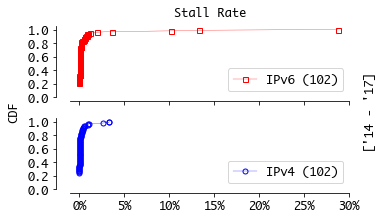

In [49]:
fig = plt.figure(figsize=(5, 3))
plt.rcParams['font.size'] = 12

yticks = np.arange(0,1.1,0.2)
xticks = np.arange(0,110,5)

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212, sharex=ax1)

ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.spines['bottom'].set_position(('axes', -0.05))
ax1.spines['left'].set_position(('axes', -0.05))

ax2.spines['right'].set_color('none')
ax2.spines['top'].set_color('none')
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
ax2.spines['bottom'].set_position(('axes', -0.05))
ax2.spines['left'].set_position(('axes', -0.05))

ax1.plot(c6.xs, c6.ps, marker='s', linewidth=0.3, markersize=5, fillstyle='none', color = 'Red')
ax2.plot(c4.xs, c4.ps, marker='o', linewidth=0.3, markersize=5, fillstyle='none', color = 'Blue')

ax1.grid(False)
ax1.set_yticks(yticks)
ax1.set_xticks(xticks)
ax1.set_ylim([0,1.05])
ax1.set_xlim([-1,30])
ax1.set_xlabel('', fontsize=12)

ax2.grid(False)
ax2.set_yticks(yticks)
ax2.set_xticks(xticks)
ax2.set_ylim([0,1.05])
ax2.set_xlim([-1,30])
ax2.set_xlabel('', fontsize=12)

ax1_ = ax1.twinx()
ax1_.spines['right'].set_color('none')
ax1_.spines['top'].set_color('none')
ax1_.spines['left'].set_color('none')
ax1_.spines['bottom'].set_color('none')
ax1_.yaxis.set_ticks_position('none')
ax1_.set_ylabel('[\'14 - \'17]', fontsize = 12)
ax1_.yaxis.set_label_coords(1.05, -0.2)
plt.setp(ax1_.get_yticklabels(), visible=False)

fig.subplots_adjust(hspace = 0.3)

def to_percent(x, position): return str(int(x)) + '%'
ax1.xaxis.set_major_formatter(FuncFormatter(to_percent))
ax2.xaxis.set_major_formatter(FuncFormatter(to_percent))

plt.setp(ax1.get_xticklabels(), visible=False)

ax1.legend(['IPv6 (102)'], fontsize=12, loc='lower right')
ax2.legend(['IPv4 (102)'], fontsize=12, loc='lower right')

ax1.yaxis.set_label_coords(-0.18, -0.2)
ax1.set_ylabel('CDF', fontsize=12)

ax1.set_title('Stall Rate', fontsize=12, y=1.05)
plt.savefig('yt-stall-rate-probes-cdf.pdf', format='pdf', bbox_inches='tight')

In [32]:
with open('yt-stall-rate-v4.csv', 'w') as f: 
    f.write('values; percentile\n')
    for x, y in zip(c4.xs, c4.ps): f.write('%.2f; %.2f\n'%(x,y))
        
with open('yt-stall-rate-v6.csv', 'w') as f: 
    f.write('values; percentile\n')
    for x, y in zip(c6.xs, c6.ps): f.write('%.2f; %.2f\n'%(x,y))        